In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import sys
sys.path.append("..")

from typing import Tuple
from matplotlib import pyplot as plt
from math import sqrt

%matplotlib inline

## Decoder Masks

In [2]:
def subsequent_mask(size: int) -> torch.Tensor:
    """
    """
    attn_shape = (1, size, size)
    sub_mask = torch.triu(
        torch.ones(size=attn_shape, dtype=torch.uint8),
        diagonal=1
    )
    return sub_mask == 0

In [3]:
subsequent_mask(3)[0]

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

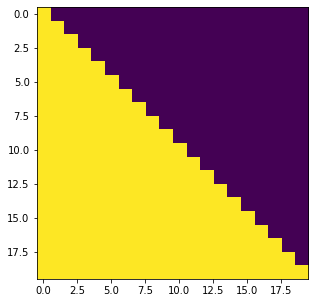

In [4]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0]);

<h2 align="center">Attention</h2>

>An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the qury with the corresponding key.

<h3 align="center">Scaled Dot-Product Attention</h3>
<div align="center">
    <div>
        <img src="images/attention.png" alt="scaled dot product attention" />
    </div>
    <div>
        attention(Q, K, V) = matmul(softmax(matmul(Q, K.t) / sqrt(d_k)), V)
    </div>
</div>
<div>
    <ol>
        <li>The input consists of queries and keys of dimension d_k, and values of d_v.</li>
        <li>We compute the dot products of the query with all keys, divide each by `sqrt(d_k)`, and apply a softmax function to obtain weights for the values.</li>
        <li>Mask is optional.</li>
        <li>Optionally we also add a dropout layer on attention weights.</li>
    </ol>
</div>

> While for small values of d_k the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of d_k.  
> Intuition: For large values of d_k. the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. Scaling is done to counteract this.

In [5]:
def attention(query: torch.Tensor, key: torch.Tensor,
              value: torch.Tensor, mask: torch.Tensor = None,
              dropout: nn.Module = None) -> Tuple[torch.Tensor, torch.Tensor]:
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
        / sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -float("inf"))
    attention_probs = softmax(scores, dim=-1)
    if dropout is not None:
        attention_probs = dropout(attention_probs)
    return torch.matmul(attention_probs, value), attention_probs